Allison Aprile

CPE645 Final Project

Dog Camera - Frame Processing Logic for Raspberry Pi

# Frame Processing Logic for Raspberry Pi
* From the Raspberry Pi, get a continuous camera stream until user exits out of video viewing window
* For each frame sampled from the camera stream (quantity determined by frames per second parameter), apply image segmentation and enhancement techniques:
  - Histogram equalization to improve contrast
  - Predict a mask for the image by doing a forward-pass through the trained U-Net
  - Blur the pixels identified as 'background' using Gaussian Blur 
  - Push frame to viewing window

In [ ]:
# For use with Raspberry Pi, need to downgrade TensorFlow
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 3.9 kB/s 
     |████████████████████████████████| 3.0 MB 44.5 MB/s 
     |████████████████████████████████| 454 kB 43.5 MB/s 
     |████████████████████████████████| 2.9 MB 43.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

In [ ]:
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Mount drive for testing images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load testing files in RGB
test1 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test1.jpg')
test2 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test2.jpg')
test3 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test3.jpg')
test4 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test4.jpg')
test5 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test5.jpg')
test6 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test6.jpg')
test7 = cv2.imread('/content/drive/My Drive/Aprile_CPE695_Final_Project/test_images/test7.jpg')

test_imgs = [test1, test2, test3, test4, test5, test6, test7]

In [ ]:
# Load model weights
model = keras.models.load_model('/content/drive/My Drive/Aprile_CPE695_Final_Project/dog_seg_model')

In [ ]:
# Confirm
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Histogram Equalization
(https://www.opencv-srf.com/2018/02/histogram-equalization.html)
* Improves contrast of an image by equalizing intensity distribution
* Typically done on grayscale images
  - To apply on color images, need to convert to a different color space (in this instance, YUV) and process each color space independently 
    - Only need to do on Y and U dimensions
  - Then, convert back to original color space

In [ ]:
# First, perform histogram equalization on image (to improve contrast)
def histogram_equalization(img):
  # Convert to YUV color space for processing
  yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

  # Perform histogram equalization
  yuv[:, :, 0] = cv2.equalizeHist(yuv[:, : , 0])

  # Convert back to BGR color space
  bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

  return bgr

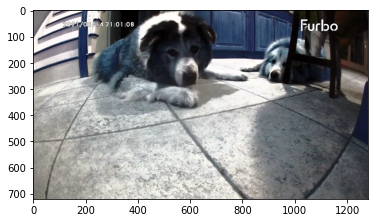

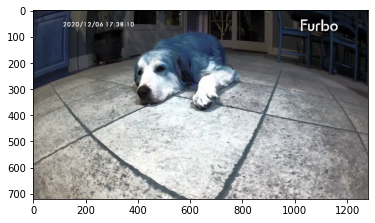

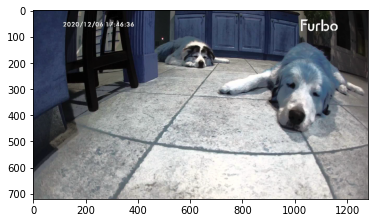

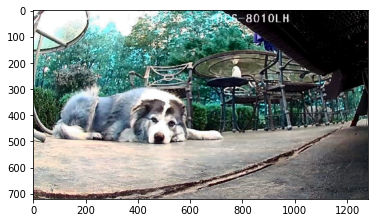

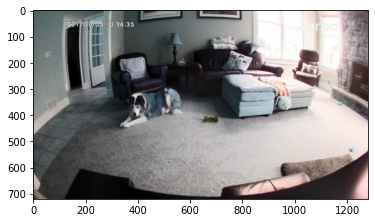

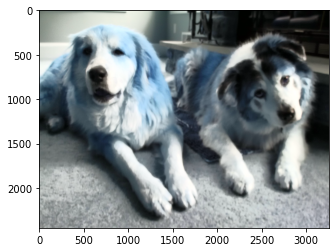

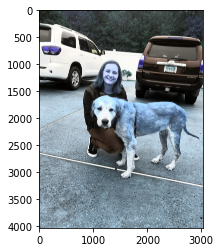

In [ ]:
# Histogram equalization test
equalized_tests = []
for t in test_imgs:
  test = histogram_equalization(t)
  equalized_tests.append(test)
  plt.imshow(test)
  plt.show()

### Mask Prediction 
* Resize image into (1, 160, 160, 3) to fit batch formatting/model specifications
* Compute a forward pass of the model to get the prediction
* Get the maximum value along the last dimension to get the mask
* **0 and 2 values specify dog and ambiguous, respectively**
* Scale mask output to be in range [0:255]
* Resize binary mask to input image dimensions

In [ ]:
# Define mask prediction function
def get_dog_mask(img):
  # Reshape/make into a 'batch' to fit classifier
  x = np.zeros((1, ) + (160, 160) + (3, ), dtype = 'float32')
  img_resized = cv2.resize(img, (160, 160))
  x[0] = img_resized

  # Make prediction
  pred = model.predict(x)

  # Define mask 
  mask = np.argmax(pred[0], axis=-1)
  
  # Markers 0 and 2 specify dog; 1 is background
  # - map 0 and 2 together
  mask[mask == 2] = 0

  # Mask output is in range [0:1]; scale to [0:255]
  mask = mask.astype('float64')
  mask = mask * 255    # Scale by 255
  mask = mask.astype('uint8')

  # Mask is now a binary image; resize to original frame size
  mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))

  return mask_resized

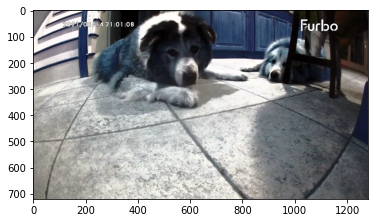

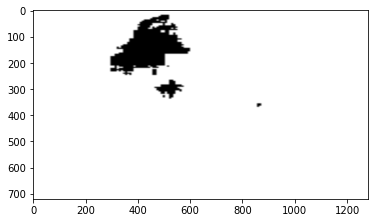

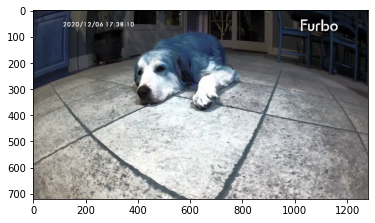

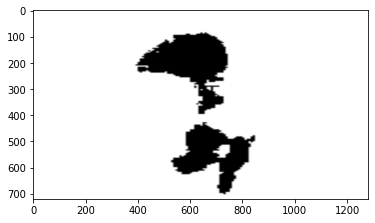

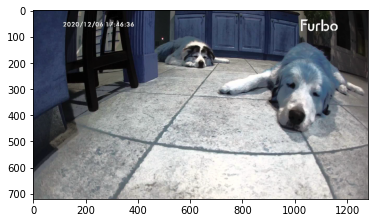

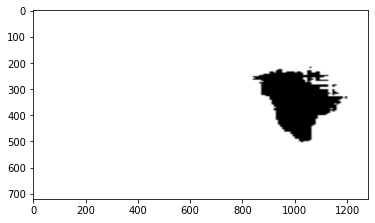

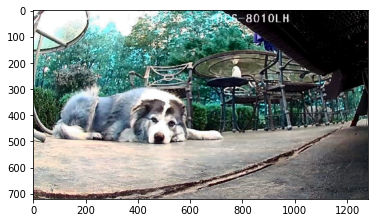

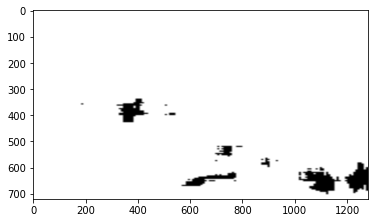

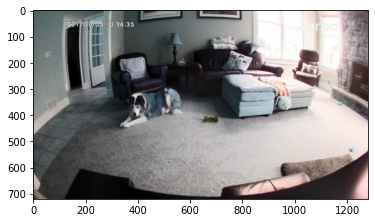

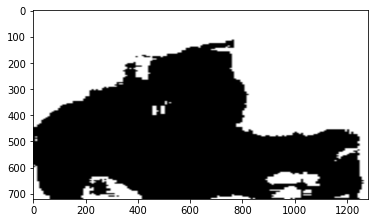

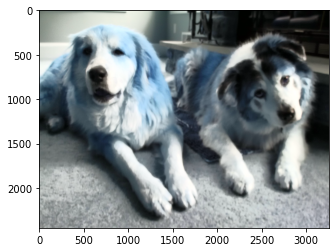

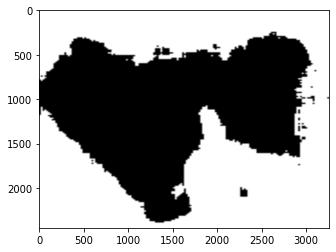

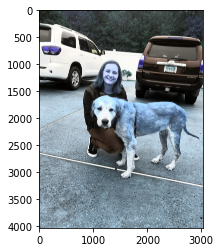

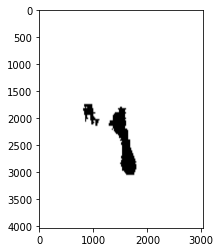

In [ ]:
# Get masks for each equalized image
masks = []
for t in equalized_tests:
  mask = get_dog_mask(t)
  plt.imshow(t)
  plt.show()
  plt.imshow(mask, cmap='gray')
  plt.show()
  masks.append(mask)

### Blur Non-Dog Pixels
* Use mask to determine which pixels do not contain a dog
* Apply Gaussian Blur (with a large kernel and sigma so not a smoothing effect) to a copy of the original image
* Stack mask into three-channels to prepare for replacement
* Replace non-dog pixels with the blurred pixels; keep the histogram equalized pixels for the dog pixels

In [ ]:
# Blur image background (using Gaussian filter)
def blur_background(img, mask):
  # Create a blurred copy of image - use large kernel and sigma so not smoothing effect
  blurred = cv2.GaussianBlur(img, (25, 25), 200)

  # Stack mask into three-channels
  mask = np.stack((mask,)*3, axis=-1)

  # Replace background pixels with blurred pixels
  camera_out = np.where(mask == 255, blurred, img)

  return camera_out

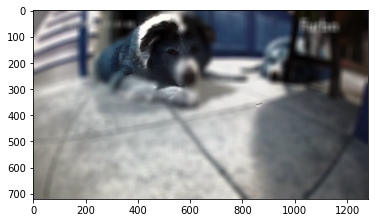

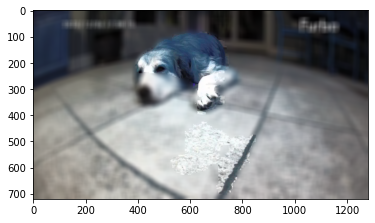

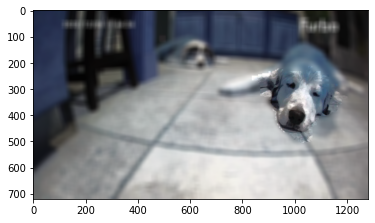

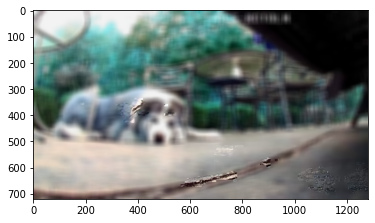

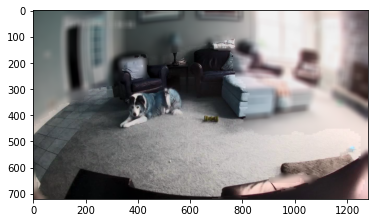

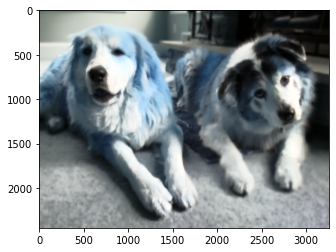

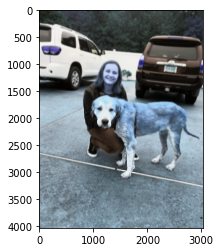

In [ ]:
# Test out blurring function on images
for t, m in list(zip(equalized_tests, masks)):
  output = blur_background(t, m)

  plt.imshow(output)
  plt.show()